### **Library**

In [2]:
# Library
# Time
from timeit import default_timer as timer
import time
from tqdm.auto import tqdm

# File
import warnings
import os
import requests
import zipfile
from pathlib import Path
from PIL import Image
import random
import chardet
import itertools

# Numerical & Data Handling
import numpy as np
import pandas as pd
import scipy as sp
import math
from typing import List, Callable, Union, Dict, Any, Tuple
import itertools

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
from sklearn.tree import plot_tree
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from pandas.plotting import lag_plot

# Machine Learning Libraries
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, ParameterGrid
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor,
							  ExtraTreesClassifier, ExtraTreesRegressor,
							  BaggingClassifier, BaggingRegressor,
							  GradientBoostingClassifier, GradientBoostingRegressor,
							  AdaBoostClassifier, AdaBoostRegressor,
							  VotingClassifier, VotingRegressor,
							  StackingClassifier, StackingRegressor)
from sklearn.linear_model import LinearRegression, LogisticRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from mlxtend.frequent_patterns import apriori, association_rules
from xgboost import XGBClassifier, XGBRegressor

# Neural Network Libraries
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import torchvision
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import huggingface
import keras
import tensorflow as tf
from transformers import pipeline

# Feature Engineering
from sklearn.preprocessing import (StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler, Normalizer,
								   LabelEncoder, OneHotEncoder, OrdinalEncoder, LabelBinarizer)
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, RFE, SequentialFeatureSelector, VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
from mlxtend.preprocessing import TransactionEncoder
from hyperopt import hp, tpe, fmin, Trials

# Dimensionality Reduction
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Time-Series Analysis
from scipy import signal
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from pmdarima import auto_arima
from prophet import Prophet

# Evaluation
from sklearn.metrics import (classification_report, pairwise_distances, silhouette_score,
							 roc_curve, auc, roc_auc_score, RocCurveDisplay,
							 confusion_matrix, ConfusionMatrixDisplay,
							 accuracy_score, recall_score, precision_score, f1_score,
							 log_loss, hinge_loss, mean_absolute_error, mean_squared_error, r2_score)
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC, ConfusionMatrix, MeanSquaredError, MeanAbsoluteError, R2Score, MetricCollection
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

# Device agnostic code
device = ('cuda' if torch.cuda.is_available() else 'cpu')


/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <EB3FF92A-5EB1-3EE8-AF8B-5923C1265422> /opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/image.so
  Reason: tried: '/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/homebrew/anaconda3/envs/venv_3.11/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Othe

### **Data Preprocessing**

In [3]:
# Load data
df = pd.read_csv('data/temp_mean_gwangju.csv', index_col=0)

# Transpose data
df = df.T

# 2-D -> 1-D
temperatures = df.values.flatten()

In [4]:
# Generate monthly anchor dates
months = pd.date_range(start='1960-01', end='2021-08', freq='MS')

# Expand each month to 31 days
synthetic_dates = []
for month in months:
	for day in range(1, 32):
		try:
			synthetic_dates.append(pd.Timestamp(year=month.year, month=month.month, day=day))
		except ValueError:
			synthetic_dates.append(pd.NaT) # Keep placeholder for invalid dates like Feb 30
			
# Map to the synthetic date range
df_mapped = pd.DataFrame({'date': synthetic_dates,
						  'value': temperatures})
df_mapped = df_mapped.dropna(subset=['date']) # Drop ghost dates

# Interpolate missing values
df_interpolated = df_mapped.sort_values('date').set_index('date').asfreq('D')
df_interpolated['value'] = df_interpolated['value'].interpolate(method='time', limit_area='inside')

# Reduce data size
df_partial = df_interpolated[int(len(df_interpolated) * 0.80):]

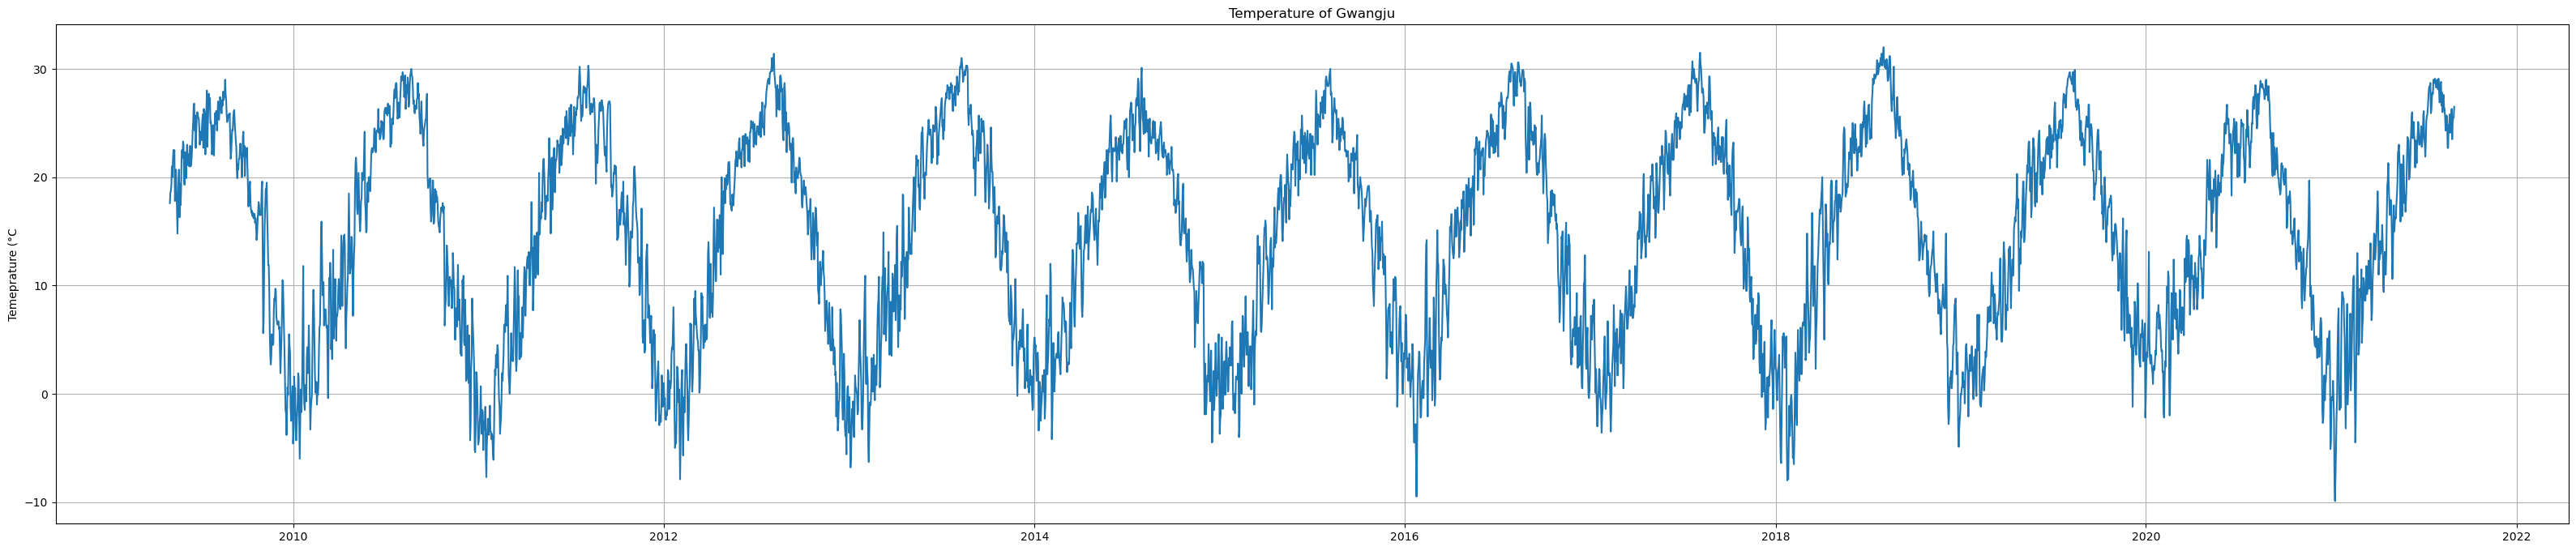

In [5]:
# Plot
plt.figure(figsize=(40, 8))
plt.plot(df_partial.index, df_partial['value'])
plt.ylabel(f"Temeprature (°C")
plt.title("Temperature of Gwangju")
plt.grid()
plt.show()

<Figure size 3200x800 with 0 Axes>

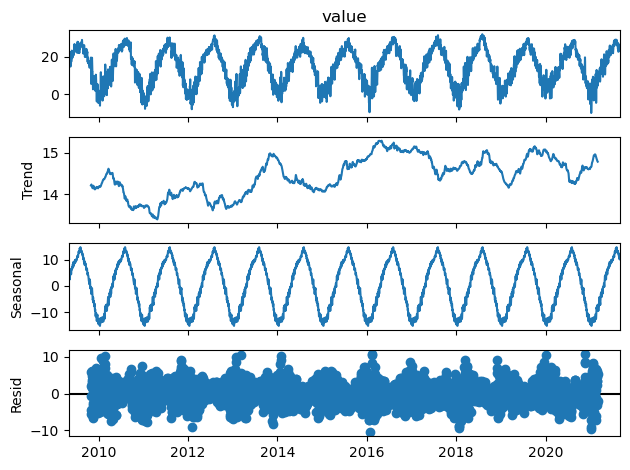

In [6]:
# Decomposition
decomp = sm.tsa.seasonal_decompose(df_partial['value'], model='additive', period=365)
plt.figure(figsize=(32, 8))
decomp.plot()
plt.show()

In [7]:
# ADF w/o differencing
adf_wo_diff = adfuller(df_partial['value'])
print(f'ADF Statistic: {adf_wo_diff[0]} | p-value: {adf_wo_diff[1]}')

ADF Statistic: -5.0198986353440915 | p-value: 2.0266283849424206e-05


ADF is not suitable for detecting deterministic seasonal patterns, only stochastic trends.
W/ strong seasonality but w/o unit root trend, the test might say it is stationary, even when seasonality dominates.

<Figure size 1200x800 with 0 Axes>

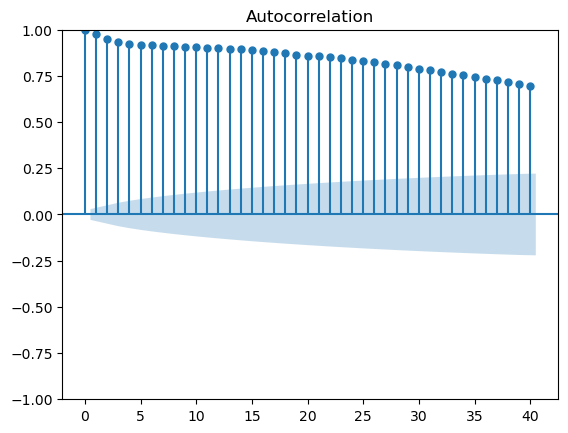

<Figure size 1200x800 with 0 Axes>

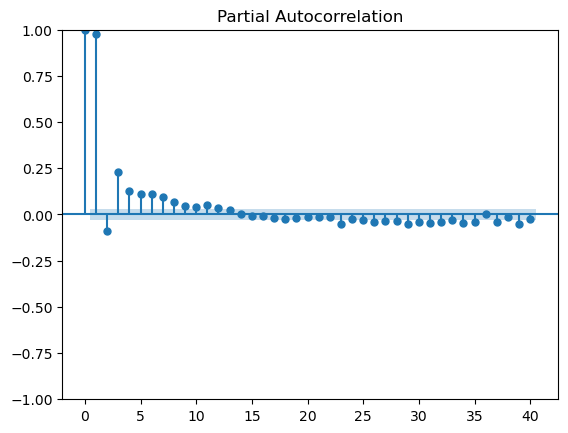

In [8]:
# ACF & PACF
plt.figure(figsize=(12, 8))
plot_acf(df_partial['value'], lags=40)
plt.show()
plt.figure(figsize=(12, 8))
plot_pacf(df_partial['value'], lags=40)
plt.show()

ACF
- Slow exponential decay usually means a non-staionary trend.
- No strong peaks at fixed intervals would indicate seasonality.

PACF
- Sharp cut-off after lag 2 or 3
- Run AR(2) or AR(3) on a staionary series

### **Statistical Modelling**

In [9]:
# Train test split
# split_idx = int(len(df_interpolated['value']) * 0.8)
# train = df_interpolated['value'][: split_idx]
# test = df_interpolated['value'][split_idx :]
train = df_interpolated[int(len(df_interpolated) * 0.8) : int(len(df_interpolated) * 0.98)]
test = df_interpolated[int(len(df_interpolated) * 0.98) :]

**ARIMA**

In [10]:
# AIC (The Lower the better)
for p in range(3):
	for q in range(3):
		try:
			model_arima = ARIMA(train['value'], order=(p, 1, q))
			result_arima = model_arima.fit()
			print(f'ARIMA({p},1,{q}) AIC: {result_arima.aic:.2f}')
		except Exception as e:
			print(f"Error fitting ARIMA({p},1,{q}): {e}")
			continue

ARIMA(0,1,0) AIC: 17471.96
ARIMA(0,1,1) AIC: 17437.78
ARIMA(0,1,2) AIC: 17159.98
ARIMA(1,1,0) AIC: 17454.12
ARIMA(1,1,1) AIC: 17383.16
ARIMA(1,1,2) AIC: 16969.65
ARIMA(2,1,0) AIC: 17204.87
ARIMA(2,1,1) AIC: 16960.34
ARIMA(2,1,2) AIC: 16957.65


In [11]:
# Training
model_arima = ARIMA(train, order=(2, 1, 2))
result_arima = model_arima.fit()
print(result_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 4054
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -8473.823
Date:                Thu, 17 Apr 2025   AIC                          16957.645
Time:                        17:04:39   BIC                          16989.181
Sample:                    05-02-2009   HQIC                         16968.816
                         - 06-06-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6560      0.052     12.526      0.000       0.553       0.759
ar.L2         -0.1801      0.044     -4.057      0.000      -0.267      -0.093
ma.L1         -0.6526      0.053    -12.379      0.0

In [12]:
# Forecasting
forecast_arima = result_arima.get_forecast(steps=len(test))
forecast_mean_arima = forecast_arima.predicted_mean
conf_int_arima = forecast_arima.conf_int()

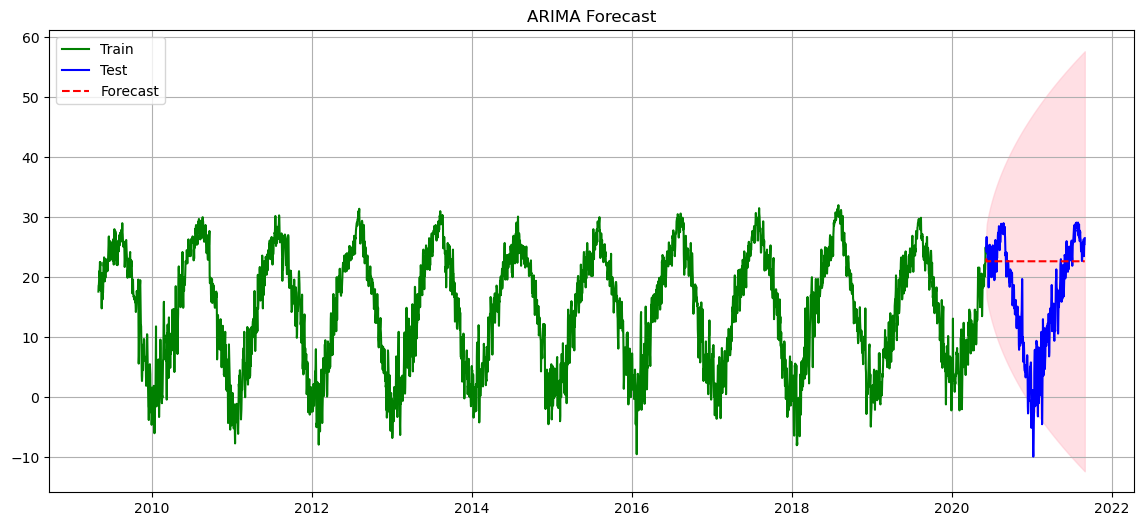

In [13]:
# Model plot
plt.figure(figsize=(14, 6))
plt.plot(train.index, train, label='Train', color='green')
plt.plot(test.index, test, label='Test', color='blue')
plt.plot(forecast_mean_arima.index, forecast_mean_arima, label='Forecast', linestyle='--', color='red')
plt.fill_between(test.index, 
				 conf_int_arima.iloc[:, 0], 
				 conf_int_arima.iloc[:, 1], 
				 color='pink', alpha=0.5)
plt.title('ARIMA Forecast')
plt.legend()
plt.grid()
plt.show()

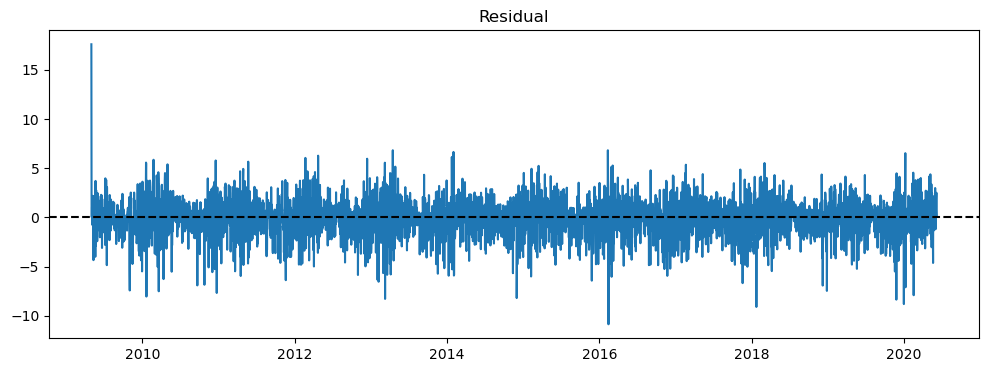

<Figure size 1200x800 with 0 Axes>

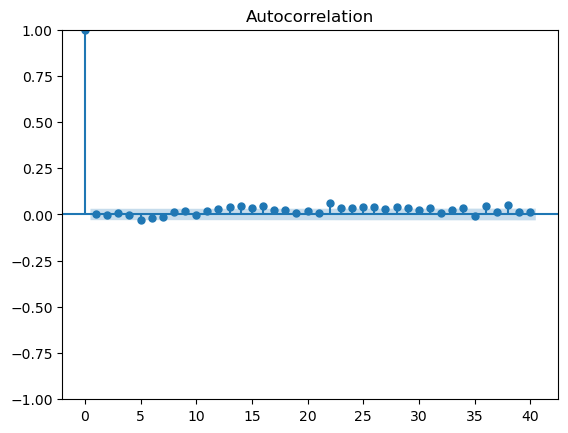

In [14]:
# Residual plot
residual_arima = result_arima.resid
plt.figure(figsize=(12, 4))
plt.plot(residual_arima)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual")
plt.show()
plt.figure(figsize=(12, 8))
plot_acf(residual_arima, lags=40)
plt.show()


If all autocorrelations are within confidence bounds, residual ≈ white noise.

In [15]:
# Ljung-box test 
lb_test_arima = acorr_ljungbox(residual_arima, lags=[20], return_df=True)
print(lb_test_arima)

      lb_stat  lb_pvalue
20  47.921508   0.000436


Ljung-box test's p-value > 0.05 means no autocorrelation in residuals.
Since 1.115011e-19 < 0.05, residual above is not white noise and requires additional analysis.

**SARIMAX**

In [16]:
# Resample for speed
train_sarimax = train.resample('M').mean()
test_sarimax = test.resample('M').mean()

# AIC
model_sarima = auto_arima(train_sarimax['value'],
						  seasonal=True,
						  m=12,
						  start_p=0, max_p=2,
						  start_q=0, max_q=2,
						  start_P=0, max_P=1,
						  start_Q=0, max_Q=1,
						  d=1, D=1,
						  stepwise=True,
						  trace=True,
						  suppress_warnings=True,
						  error_action='ignore')

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=505.931, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=469.958, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.16 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=485.519, Time=0.01 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=447.003, Time=0.07 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=461.358, Time=0.06 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=446.673, Time=0.08 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=486.608, Time=0.02 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.32 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=471.128, Time=0.04 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=inf, Time=0.58 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(2,1,0)(0,1,1)[12] intercept   : AIC=448.672, Time=0.10 sec

Best model:  ARIMA(2,1,0)(0,1,1)[12]          
Total

In [17]:
# Training
model_sarimax = SARIMAX(train_sarimax['value'],
						order=model_sarima.order,
						seasonal_order=model_sarima.seasonal_order,
						enforce_stationarity=False,
						enforce_invertibility=False)
result_sarimax = model_sarimax.fit()
print(result_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                value   No. Observations:                  134
Model:             SARIMAX(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -193.999
Date:                              Thu, 17 Apr 2025   AIC                            395.997
Time:                                      17:04:42   BIC                            406.726
Sample:                                  05-31-2009   HQIC                           400.347
                                       - 06-30-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4083      0.103     -3.973      0.000      -0.610      -0.207
ar.L2         -0.15

In [18]:
# Forecasting
forecast_sarimax = result_sarimax.get_forecast(steps=len(test_sarimax))
forecast_mean_sarimax = forecast_sarimax.predicted_mean
conf_int_sarimax = forecast_sarimax.conf_int()

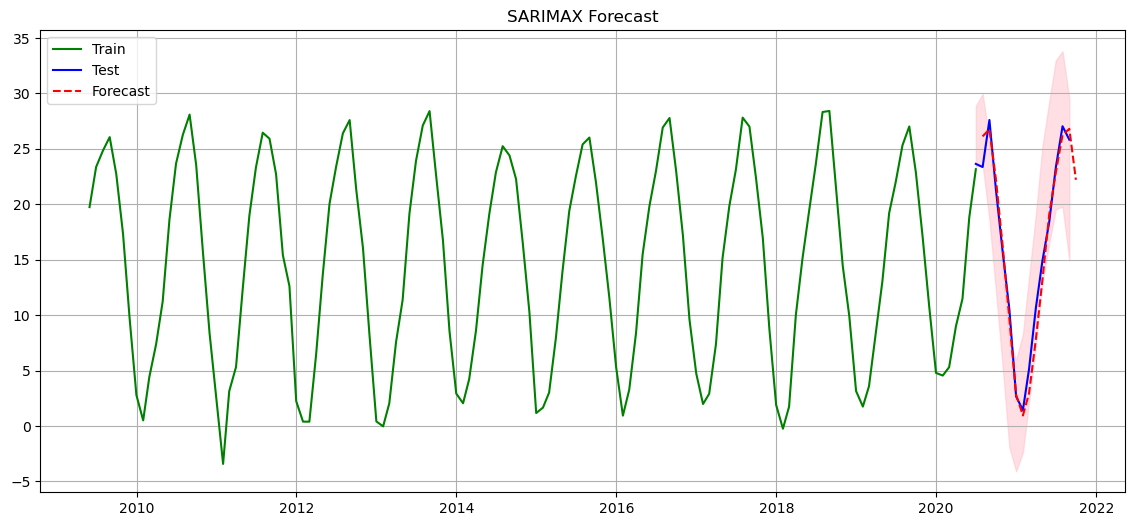

In [19]:
# # Model plot
plt.figure(figsize=(14, 6))
plt.plot(train_sarimax.index, train_sarimax, label='Train', color='green')
plt.plot(test_sarimax.index, test_sarimax, label='Test', color='blue')
plt.plot(forecast_mean_sarimax.index, forecast_mean_sarimax, label='Forecast', linestyle='--', color='red')
plt.fill_between(test_sarimax.index, 
				 conf_int_sarimax.iloc[:, 0], 
				 conf_int_sarimax.iloc[:, 1], 
				 color='pink', alpha=0.5)
plt.title('SARIMAX Forecast')
plt.legend()
plt.grid()
plt.show()

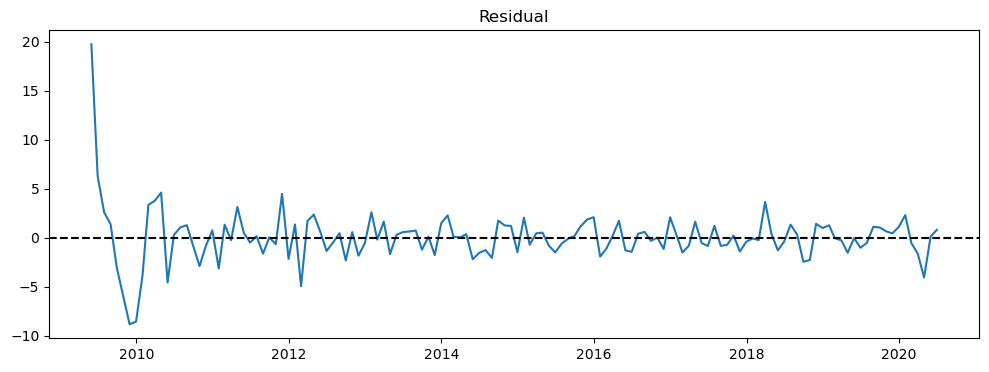

<Figure size 1200x800 with 0 Axes>

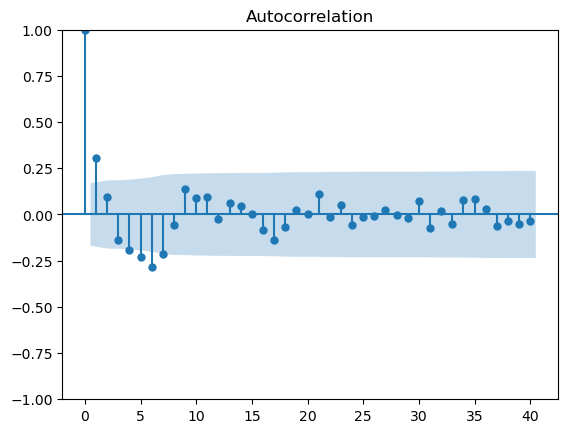

In [20]:
# Residual plot
residual_sarimax = result_sarimax.resid
plt.figure(figsize=(12, 4))
plt.plot(residual_sarimax)
plt.axhline(0, color='black', linestyle='--')
plt.title("Residual")
plt.show()
plt.figure(figsize=(12, 8))
plot_acf(residual_sarimax, lags=40)
plt.show()

In [21]:
# Ljung-box test 
lb_test_sarimax = acorr_ljungbox(residual_sarimax, lags=[20], return_df=True)
print(lb_test_sarimax)

      lb_stat  lb_pvalue
20  58.947905    0.00001


**Exponential smoothing**

In [22]:
# Training
model_es = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=365)
fit_es = model_es.fit()

# Forecasting
forecast_es = fit_es.forecast(365)

/opt/homebrew/anaconda3/envs/venv_3.11/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


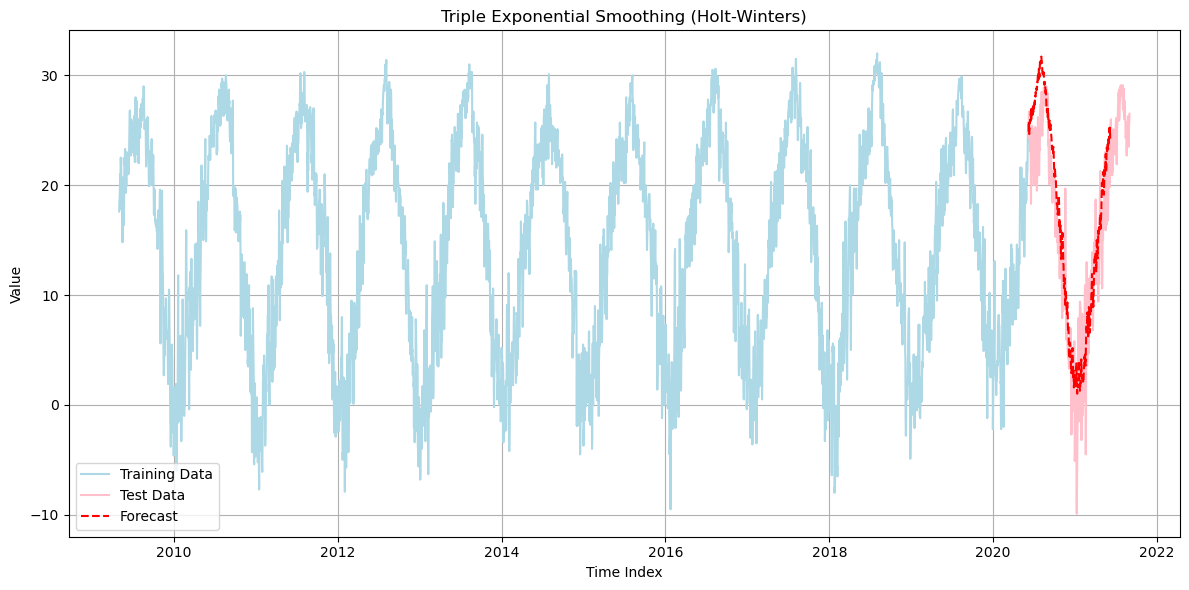

In [23]:
# Model plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data', color='lightblue')
plt.plot(test, label='Test Data', color='pink')
#plt.plot(fit_es.fittedvalues, label='Smoothed (Fitted)', linestyle='--', color='blue')
plt.plot(forecast_es.index, forecast_es, label='Forecast', linestyle='--', color='red')
plt.title('Triple Exponential Smoothing (Holt-Winters)')
plt.xlabel('Time Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### **NN Modelling**

**Data Preparation**

In [24]:
def create_seq2seq(data, input_len, output_len):
	"""
	Convert a 1D time series into input-output sequences for seq2seq models.

	Parameters:
		data (np.ndarray): 1D array of time series values. Shape: (total_timesteps,)
		input_len (int): Number of time steps in the input sequence.
		output_len (int): Number of time steps to predict.

	Returns:
		X (np.ndarray): Input sequences. Shape: (num_samples, input_len)
		y (np.ndarray): Output sequences. Shape: (num_samples, output_len)
	"""
	
	X, y = [], []
	
	# Loop over the time series to extract windows
	for i in range(len(data) - input_len - output_len + 1):
		X.append(data[i : i + input_len]) # X: <class 'list'> | X[0]: <class 'numpy.ndarray'> | X[0] shape: (input_len, )
		y.append(data[i + input_len : i + input_len + output_len]) # y[0] shape: (output_len,)
	
	return np.array(X), np.array(y) # X shape: (num_samples, input_len) | y shape: (num_samples, output_len)

In [25]:
def train_model(model, dl_train, dl_val,
				loss_fn, optimizer, device,
				epochs=50, patience=5):
	"""
	Train a model.

	Parameters:
		model (torch.nn.Module): The model to train.
		dl_train (DataLoader): Training data.
		dl_val (DataLoader): Validation data.
		loss_fn (torch.nn.Module): Loss function (e.g. MSELoss).
		optimizer (torch.optim.Optimizer): Optimizer.
		device (torch.device): CPU or CUDA.
		epochs (int): Maximum number of epochs.
		patience (int): Early stopping patience.

	Returns:
		model: Trained model.
		history: dict with train and val losses per epoch.
	"""
	
	best_val_loss = float('inf')
	counter = 0
	history = {'train': [], 'val': []}
	
	for epoch in range(epochs):
		# Training
		model.train()
		loss_train_total = 0
		for i, (X_batch, y_batch) in enumerate(dl_train):
			X_batch, y_batch = X_batch.to(device), y_batch.to(device)
			y_pred = model(X_batch)
			loss = loss_fn(y_pred, y_batch)
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
			loss_train_total += loss.item()
		loss_train_avg = loss_train_total / len(dl_train)

		# Validation
		model.eval()
		loss_val_total = 0
		with torch.inference_mode():
			for i, (X_batch, y_batch) in enumerate(dl_val):
				X_batch, y_batch = X_batch.to(device), y_batch.to(device)
				y_pred = model(X_batch)
				loss = loss_fn(y_pred, y_batch)
				loss_val_total += loss.item()
		loss_val_avg = loss_val_total / len(dl_val)
		
		history['train'].append(loss_train_avg)
		history['val'].append(loss_val_avg)

		# Early stopping
		if loss_val_avg < best_val_loss:
			best_val_loss = loss_val_avg
			counter = 0
		else:
			counter += 1
			if counter > patience:
				print("Early stopping triggered.")
				break

		print(f"Epoch {epoch + 1} / {epochs}") 
		print(f"Train loss: {loss_train_avg:.4f}")
		print(f"Val loss: {loss_val_avg:.4f}")

	return model, history

In [26]:
# Data split
df_nn = df_interpolated[int(len(df_interpolated) * 0.8):]

n_total = len(df_nn)
n_test = int(n_total * 0.2)
n_val = int(n_total * 0.2)
n_train = n_total - n_val - n_test

series = df_nn['value'].values.reshape(-1, 1)
series_train = series[:n_train]
series_val = series[n_train:n_train + n_val]
series_test = series[n_train + n_val:]

# Date split
dates = df_nn.index if isinstance(df_nn.index, pd.DatetimeIndex) else df_nn['date']
train_dates = dates[:n_train]
val_dates = dates[n_train:n_train + n_val]
test_dates = dates[n_train + n_val :]

# Scaling
scaler = MinMaxScaler()
series_train_scaled = scaler.fit_transform(series_train)
series_val_scaled = scaler.transform(series_val)
series_test_scaled = scaler.transform(series_test)

In [27]:
# Setting
input_len = 365
output_len = 7
batch_size = 64

# Seq2Seq
X_train, y_train = create_seq2seq(series_train_scaled.squeeze(), input_len, output_len)
X_val, y_val = create_seq2seq(series_val_scaled.squeeze(), input_len, output_len)

# Array -> Tensor
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Tensor -> TensorDataset 
ds_train = TensorDataset(X_train, y_train) 
ds_val = TensorDataset(X_val, y_val)

# TensorDataset -> DataLoader
dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=False)

**CNN**

In [28]:
class cnn_model_v0(nn.Module):
	def __init__(self, n_features, output_len, n_channels, kernel_size, stride, padding, dropout=0.1):
		"""
		A simple 1D CNN model for time series forecasting using two convolutional layers,
		batch normalization, ReLU activation, dropout, and a fully connected output layer.

		Parameters:
			n_features (int): Number of input features per time step.
			output_len (int): Length of the output sequence to predict.
			n_channels (int): Number of channels (filters) in the convolutional layers.
			kernel_size (int): Size of the 1D convolution kernel.
			stride (int): Stride size for convolutions.
			padding (int or None): Padding size. If None, automatically set for "same" padding.
			dropout (float): Dropout rate for regularization.
		"""
		
		super().__init__()
		
		if padding is None:
			padding = (kernel_size - 1) // 2
		
		self.conv_stack = nn.Sequential(nn.Conv1d(in_channels=n_features,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=1,
												  dilation=1),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=2,
												  dilation=2),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=4,
												  dilation=4),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=8,
												  dilation=8),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=16,
												  dilation=16),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=32,
												  dilation=32),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout),
										nn.Conv1d(in_channels=n_channels,
												  out_channels=n_channels,
												  kernel_size=kernel_size,
												  stride=stride,
												  padding=64,
												  dilation=64),
										nn.BatchNorm1d(n_channels),
										nn.ReLU(),
										nn.Dropout(dropout))
		
		self.pool = nn.AdaptiveAvgPool1d(output_size=1)
		self.flatten = nn.Flatten()
		self.fc = nn.Linear(in_features=n_channels, out_features=output_len)
	
	def forward(self, x):
		"""
		Define the forward pass of the CNN model.

		Parameters:
			x (torch.Tensor): Input tensor of shape (batch_size, input_len, n_features)

		Returns:
			torch.Tensor: Output tensor of shape (batch_size, output_len)
		"""
		x = x.permute(0, 2, 1) # -> (batch_size, n_features, input_len)
		x = self.conv_stack(x)
		x = self.pool(x) # -> (batch_size, n_channels, 1)
		x = self.flatten(x) # -> (batch_size, n_channels)
		return self.fc(x)

**LSTM**

In [ ]:
class lstm_model_v0(nn.Module):
	def __init__(self, n_features, hidden_size, num_layers, output_size):
		"""
		LSTM-based sequence-to-sequence model.

		Parameters:
			n_features (int): Number of input features per time step.
			hidden_size (int): Number of hidden units in the LSTM.
			num_layers (int): Number of stacked LSTM layers.
			output_len (int): Number of future time steps to predict.
		"""
		
		super().__init__()
		self.lstm = nn.LSTM(input_size=n_features, 
					  		hidden_size=hidden_size, 
							num_layers=num_layers,
							batch_first=True,
							bidirectional=True)
		self.fc = nn.Linear(in_features=hidden_size, 
							out_features=output_size)
	
	def forward(self, x):
		"""
		Parameters:
			x (Tensor): Shape = (batch_size, seq_len, input_size)

		Returns:
			Tensor: Shape = (batch_size, output_size)
		"""
		
		x, (h_n, c_n) = self.lstm(x) # x: Hidden state for every time step | x.shape (batch_size, seq_len, hidden_size)
									 # h_n: Last hidden state from the last time step from each layer | h_n.shape (num_layers, batch_size, hidden_size)
									 # h_n: Last cell state | c_n.shape (num_layers, batch_size, hidden_size)
		x = x[:, -1, :] # Hidden states from the last time step of the last layer | output.shape (batch_size, hiden_size)
		
		return self.fc(x)

**Transformer**

In [30]:
class encoder_only_transformer_model_v0(nn.Module):
	def __init__(self, input_len, output_len, d_model, nhead, num_layers, dropout):
		"""
		Transformer model for time series forecasting using only the encoder block.
		
		Parameters:
			input_len (int): Length of the input time series.
			output_len (int): Length of the output prediction (forecast horizon).
			d_model (int): Dimension of the transformer model.
			nhead (int): Number of attention heads.
			num_layers (int): Number of transformer encoder layers.
			dropout (float): Dropout rate.
		"""
		
		super().__init__()
		
		self.input_len = input_len
		self.output_len = output_len
		
		self.embedding = nn.Linear(in_features=1, out_features=d_model)
		self.ln_embedding = nn.LayerNorm(normalized_shape=d_model)
		
		self.positional_encoding = self._generate_positional_encoding(input_len, d_model)
		
		encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
		self.transformer_encoder = nn.TransformerEncoder(encoder_layer=encoder_layer, num_layers=num_layers)
		self.ln_transformer_encoder = nn.LayerNorm(normalized_shape=d_model)
		
		self.decoder = nn.Sequential(nn.Linear(d_model * input_len, 128),
							   		 nn.ReLU(),
									 nn.Linear(128, output_len))
		
	def forward(self, x):
		"""
		Forward pass for the transformer model.

		Args:
			x (torch.Tensor): Input tensor of shape (batch_size, input_len, 1)

		Returns:
			torch.Tensor: Output tensor of shape (batch_size, output_len)
		"""
		
		x = self.embedding(x)
		x += self.positional_encoding.to(x.device)
		x = self.transformer_encoder(x)
		
		return self.decoder(x.reshape(x.size(0), -1))
	
	def _generate_positional_encoding(self, seq_len, d_model):
		"""
		Generate sinusoidal positional encodings for the input sequence.

		Args:
			seq_len (int): Length of the sequence.
			d_model (int): Dimension of the model.

		Returns:
			torch.Tensor: Positional encoding tensor of shape (1, seq_len, d_model)
		"""
		
		pos = torch.arange(seq_len, dtype=torch.float32).unsqueeze(1)
		i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)
		angle_rads = pos / np.power(10000, 2 * (i // 2) / d_model)
		
		pe = torch.zeros(seq_len, d_model)
		pe[:, 0::2] = torch.sin(angle_rads[:, 0::2])
		pe[:, 1::2] = torch.cos(angle_rads[:, 1::2])
		
		return pe.unsqueeze(0)

**Analysis**

In [38]:
# Instantiation
model_cnn = cnn_model_v0(n_features=1, output_len=output_len, n_channels=64, kernel_size=5, stride=1, padding=None, dropout=0.1).to(device)
model_lstm = lstm_model_v0(n_features=1, hidden_size=256, num_layers=5, output_size=output_len).to(device)
model_transformer = encoder_only_transformer_model_v0(input_len=input_len, output_len=output_len, d_model=64, nhead=4, num_layers=2, dropout=0.0).to(device)

model = model_lstm
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [39]:
# Modelling
model, history = train_model(model=model,
							 dl_train=dl_train,
							 dl_val=dl_val,
							 loss_fn=loss_fn,
							 optimizer=optimizer,
							 device=device,
							 epochs=5,
							 patience=5)

Epoch 1 / 5
Train loss: 0.1275
Val loss: 0.0525
Epoch 2 / 5
Train loss: 0.0567
Val loss: 0.0447
Epoch 3 / 5
Train loss: 0.0362
Val loss: 0.0258
Epoch 4 / 5
Train loss: 0.0143
Val loss: 0.0112
Epoch 5 / 5
Train loss: 0.0110
Val loss: 0.0117


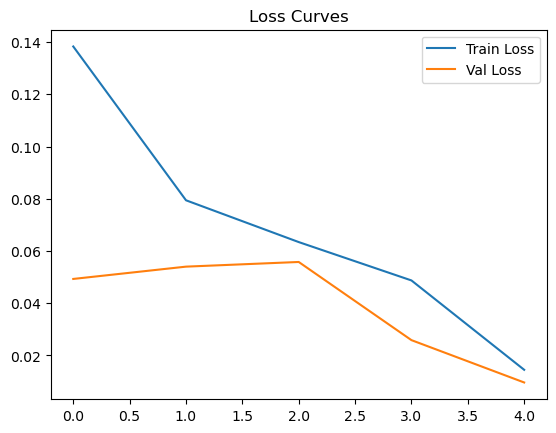

In [33]:
# Train & Validation loss
plt.plot(history['train'], label='Train Loss')
plt.plot(history['val'], label='Val Loss')
plt.legend()
plt.title("Loss Curves")
plt.show()

In [ ]:
def forecast_using_preds(model, initial_window, forecast_horizon, input_len, output_len, scaler, device):
    """
    Iterative forecasting using model predictions.

    Parameters:
        model (torch.nn.Module): Trained model.
        initial_window (np.ndarray): 1D array of last input_len scaled values.
        forecast_horizon (int): How many future steps to predict.
        output_len (int): How many steps the model predicts at once.
        scaler (MinMaxScaler): For inverse transform.
        device (torch.device): CPU or CUDA.

    Returns:
        predictions_rescaled (np.ndarray): Rescaled full forecast.
    """
    model.eval()
    window = initial_window.copy()
    predictions = []
    steps_done = 0
    with torch.inference_mode():
        while steps_done < forecast_horizon:
            window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            y_pred = model(window_tensor).detach().cpu().numpy().squeeze()

            # Make sure y_pred is 1D array
            if y_pred.ndim == 0:
                y_pred = np.array([y_pred])

            steps_to_add = min(output_len, forecast_horizon - steps_done)
            predictions.extend(y_pred[:steps_to_add])

            steps_done += steps_to_add

            # Slide window forward
            window = np.append(window, y_pred[:steps_to_add])
            window = window[-input_len:]  # Keep window size

    # Inverse transform
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()

    return predictions_rescaled

In [ ]:
def forecast_using_truth(model, initial_window, test_series_scaled, input_len, output_len, scaler, device):
    """
    Iterative forecasting using ground truth values.

    Parameters:
        model (torch.nn.Module): Trained model.
        initial_window (np.ndarray): 1D array of last input_len scaled values.
        test_series_scaled (np.ndarray): Ground truth test data (scaled).
        output_len (int): How many steps model predicts at once.
        scaler (MinMaxScaler): To inverse transform results.
        device (torch.device): CPU or CUDA.

    Returns:
        predictions_rescaled (np.ndarray): Forecasted full sequence.
    """
    model.eval()
    window = initial_window.copy()
    predictions = []
    with torch.inference_mode():
        for step in range(len(test_series_scaled)):
            window_tensor = torch.tensor(window, dtype=torch.float32).unsqueeze(0).unsqueeze(-1).to(device)
            y_pred = model(window_tensor).cpu().numpy().squeeze()

            # Ensure y_pred is at least 1D array
            if y_pred.ndim == 0:
                y_pred = np.array([y_pred])

            # Take first prediction
            next_value = y_pred[0]
            predictions.append(next_value)

            # Slide window using true value from test_series_scaled
            true_next = test_series_scaled[step]
            window = np.append(window[1:], true_next)

    # Inverse transform
    predictions_rescaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).squeeze()

    return predictions_rescaled

In [40]:
forecast_horizon = len(series_test_scaled)
initial_input = np.concatenate([series_train_scaled, series_val_scaled])[-input_len:].squeeze()

# Case 1
preds_using_preds = forecast_using_preds(model, initial_input, forecast_horizon, input_len, output_len, scaler, device)

# Case 2
preds_using_truth = forecast_using_truth(model, initial_input, series_test_scaled.squeeze(), input_len, output_len, scaler, device)

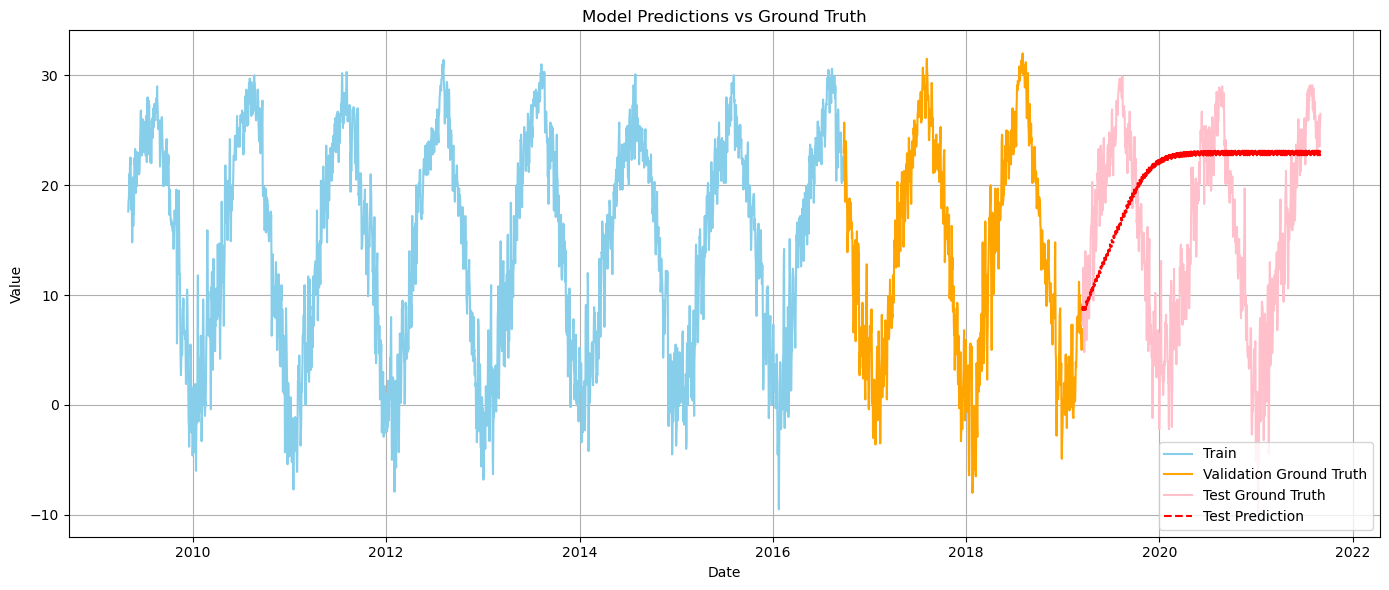

In [ ]:
# Extract true values
true_vals = df_nn['value'].values

# Plot
plt.figure(figsize=(14, 6))

# True values
plt.plot(train_dates, true_vals[:n_train], label='Train Ground Truth', color='skyblue')
plt.plot(val_dates, true_vals[n_train:n_train + n_val], label='Validation Ground Truth', color='orange')
plt.plot(test_dates, true_vals[n_train + n_val :], label='Test Ground Truth', color='pink')

# Predictions
plt.plot(test_dates, preds_using_preds, label='Test Prediction', linestyle='--', color='red')

plt.title("Model Predictions vs Ground Truth")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()